Starting Portfolio Value: 100000.00
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
increasing
有上升趋势,使用格兰维尔法则
BUY CREATE, 195.08
--- Position Begin
- Size: 40
- Price: 195.69
- Price orig: 0.0
- Closed: 0
- Opened: 40
- Adjbase: 195.69
--- Position End
increasing
有上升趋势,使用格兰维尔法则
--- Position Begin
- Size: 40
- Price: 195.69
- Price orig: 0.0
- Closed: 0
- Opened: 40
- Adjbase: 192.78
--- Position End
increasing
有上升趋势,使用格兰维尔法则
--- Position Begin
- Size: 40
- Price: 195.69
- Price orig: 0.0
- Closed: 0
- Opened: 40
- Adjbase: 198.56
--- Position End
increasing
有上升趋势,使用格兰维尔法则
BUY CREATE, 198.56
--- Position Begin
- Size: 80
- Price: 195.12
- Price orig: 195.69
- Closed: 0
- Opened: 40
- Adjbase: 194.55
--- Position End
increasing
有上升趋势,使用格兰维尔法则
--- Position Begin
- Size: 80
- Price: 195.12
- Price orig: 195.69
- Closed: 0
- Opened: 40
- Adjbase: 196.77
--- Position End
increasing
有上升趋势,使用格兰维尔法则
BUY CREATE, 196.77
--- Posi

<IPython.core.display.Javascript object>


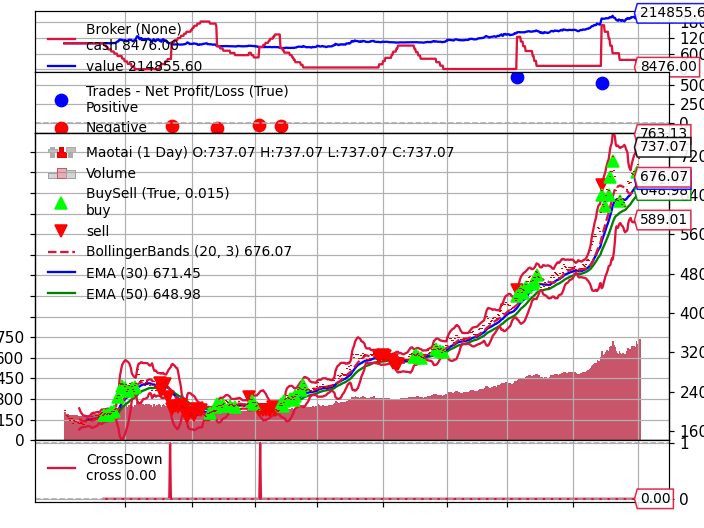

In [70]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  
import os.path  
import sys  

# 导入backtrader
import backtrader as bt
import numpy as np
import pymannkendall as mk

# 创建策略
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15), ('trend_test_period', 30), ("period", 20), ("devfactor", 3), ("debug", False), ("size", 1),
        ("fast_ma", 30),
        #止损率为sl 
        ('sl', 8.0),
        #止盈率是止损率的rr_ratio倍
        ('rr_ratio', 5),
        ('n', 5),
        ("flag", True) # flag == True多头,否则空头
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        #if self.params.printlog or doprint:
         #    dt = dt or self.datas[0].datetime.date(0)
          #   print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # 创建line对象，跟踪收盘价
        self.dataclose = self.datas[0].close
        #设置变点检验的区间
        self.data_trend_test = self.datas[0].get(size=self.p.trend_test_period)  # ago defaults to 0
        #初始化order变量
        self.order, self.sl_order, self.tp_order = None, None, None
        self.buyprice = None
        self.buycomm = None
        #
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        #初始化均线
        self.fast_ma = bt.ind.EMA(period=self.p.fast_ma)
       
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order已经创建执行
            return

        # 钱不够的情况下Broker可以阻止order的创建
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size))
            

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        else:
            #交易关闭后取消sl_order和tp_order变量
            if self.sl_order:
                self.broker.cancel(self.sl_order)
                self.sl_order = None
                self.sl_price = 0.0

            if self.tp_order:
                self.broker.cancel(self.tp_order)
                self.tp_order = None
                self.tp_price = 0.0
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # 打印持仓信息
        print(self.position)
        #止损和利润确认
        if self.position:
            #多头时，计算止损价格
            price_sl_long = self.position.price * (1 - self.p.sl / 100)
            #空头时，计算止损价格价格
            price_sl_short = self.position.price * (1 + self.p.sl / 100)
            #多头时，计算止盈价格
            price_tp_long = self.position.price * (1 + self.p.sl / 100 * self.p.rr_ratio)
            #空头时，计算止盈价格
            price_tp_short = self.position.price * (1 - self.p.sl / 100 * self.p.rr_ratio)
            
            # cancel existing stop loss and take profit orders
            if self.sl_order:
                self.broker.cancel(self.sl_order)

            if self.tp_order:
                self.broker.cancel(self.tp_order)

            # check & update stop loss order
            self.sl_price = 0.0
            #多头时，设置止损价格
            if self.position.size > 0 and price_sl_long !=0: self.sl_price = price_sl_long
            #空头时，设置止损价格
            if self.position.size < 0 and price_sl_short !=0: self.sl_price = price_sl_short
            #止损平仓
            if self.sl_price != 0.0:
                self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop,
                                                        price=self.sl_price)
            # check & update take profit order
            self.tp_price = 0.0
            #多头时，设置止盈价格
            if self.position.size > 0 and price_tp_long !=0: self.tp_price = price_tp_long
            #空头时，设置止盈价格
            if self.position.size < 0 and price_tp_short !=0: self.tp_price = price_tp_short
            #止盈平仓
            if self.tp_price != 0.0:
                self.tp_order = self.order_target_value(target=0.0, exectype=bt.Order.Limit,
                                                        price=self.tp_price)
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(trend)
        #没有趋势时，用布林线法则
        if trend == 'no trend':
            print('没有趋势,使用布林线法则')
            #下穿布林线下轨，做多
            if self.dataclose[0] < self.boll.lines.bot:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
            #上穿布林线上轨，做空
            elif self.data.close[0] > self.boll.lines.top:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell() 
        # 有上升趋势时，采用格兰维尔法则，实现买点123和卖点4
        elif trend == 'increasing':  
            print('有上升趋势,使用格兰维尔法则')
            #一号买点和二号买点,趋势向上，收盘价上穿均线
            if self.dataclose[0] > self.fast_ma and self.dataclose[-1] < self.fast_ma:
                print('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
            #三号买点，趋势向上，收盘价下跌又上升并且未跌破均线
            elif self.dataclose[-2] > self.dataclose[-1] and self.dataclose[-1] < self.dataclose[0] and self.dataclose[-1] > self.fast_ma:
                print('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
            #四号卖点，股价急速上升，可能会下跌(连续两天上升超过7个点为急速上升)
            elif (self.dataclose[0] - self.dataclose[-1])/self.dataclose[-1] > 0.7 and (self.dataclose[-1] - self.dataclose[-2])/self.dataclose[-2] > 0.7:
                print('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()
            else:
                pass
            # 有下降趋势时，采用格兰维尔法则，实现卖点123和买点4
        else:
            print('有下降趋势,使用格兰维尔法则')
            #一号卖点和二号卖点,趋势向下，收盘价下穿穿均线
            if self.dataclose[0] < self.fast_ma and self.dataclose[-1] > self.fast_ma:
                print('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()
            #三号卖点，趋势向下，收盘价上升又下跌并且未穿均线
            elif self.dataclose[-2] < self.dataclose[-1] and self.dataclose[-1] > self.dataclose[0] and self.dataclose[-1] < self.fast_ma:
                print('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()
            #四号买点，股价急速下降，可能会上升(连续两天下降超过7个点为急速下降)
            elif (self.dataclose[0] - self.dataclose[-1])/self.dataclose[-1] > 0.7 and (self.dataclose[-1] - self.dataclose[-2])/self.dataclose[-2] > 0.7:
                print('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
            else:
                pass
    
if __name__ == '__main__':
    # 创建一个cerebro实体
    cerebro1 = bt.Cerebro() # 多头

    # 向实体中添加策略
    cerebro1.addstrategy(TestStrategy, flag=True) # 多头

    # 创建 Data Feed
    data = bt.feeds.GenericCSVData(
        dataname='D:\desktop\Maotai.csv',
        fromdate=datetime.datetime(2015, 1, 5),
        todate=datetime.datetime(2018, 1, 5),
        nullvalue=0.0,
        dtformat=('%Y-%m-%d'),
        datetime=0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        volume =5, 
        openinterest=-1,
        reverse=False)

    # 在cerebro中添加数据
    cerebro1.adddata(data)

    # 设置初始现金值
    cerebro1.broker.setcash(100000.0)

    # 固定交易的手数
    cerebro1.addsizer(bt.sizers.FixedSize, stake=40)

    # 设置交易手续费
    cerebro1.broker.setcommission(commission=0.0)

    # 打印开始的金额
    print('Starting Portfolio Value: %.2f' % (cerebro1.broker.getvalue()))

    # 运行
    cerebro1.run()

    # 打印最终的金额
    # print('Final Portfolio Value: %.2f' % (cerebro1.broker.getvalue() + cerebro2.broker.getvalue()))
    print('1 Portfolio Value: %.2f' % cerebro1.broker.getvalue())
    cerebro1.plot(style='candlestick')